### Synthetic dataset generation

In [1]:
import torch
from torch.utils.data import TensorDataset, DataLoader

torch.manual_seed(1337)  

# Parameters
num_samples = 1000  #Corresponds to m in the paper
dim_x = 10  
dim_y = 10  

# Dataset creation

# Matrix creation
def random_positive_diagonal_matrix(n, m):
    # Generate evenly spaced positive distinct values
    values = torch.linspace(1, 10, steps=n)
    # Shuffle the values to make them random
    values = values[torch.randperm(n)]
    # Create a diagonal matrix of size (n x n)
    D = torch.diag(values)
    # If n != m, pad or truncate the diagonal matrix to size (n x m)
    if n < m:
        D = torch.cat([D, torch.zeros(n, m - n)], dim=1)
    elif n > m:
        D = D[:m, :m]
    return D
    
def random_orthogonal_matrix(n,m):
    U, _ = torch.linalg.qr(torch.randn(n, m), mode='reduced')
    return U
    
def diagonal_matrix_with_d_distinct_values(m, n, d):
    min_dim = min(m, n)
    if d > min_dim or d < 1:
        raise ValueError("d must satisfy 1 <= d <= min(m, n)")

    # Generate d distinct positive values
    distinct_values = torch.linspace(1, 10, steps=d)

    # Repeat the distinct values to fill the diagonal
    diagonal_values = torch.cat([distinct_values, distinct_values[:min_dim - d]])

    # Shuffle the diagonal values to randomize their order
    diagonal_values = diagonal_values[torch.randperm(min_dim)]

    # Create a rectangular diagonal matrix
    D = torch.zeros(m, n)
    for i in range(min_dim):
        D[i, i] = diagonal_values[i]
    return D

def diagonal_matrix_with_d_zeros(m, n, d):

    min_dim = min(m, n)
    if d > min_dim or d < 0:
        raise ValueError("d must satisfy 0 <= d <= min(m, n)")

    # Generate non-zero values for the diagonal
    non_zero_values = torch.ones(min_dim - d)  # You can replace this with other positive values

    # Combine zeros and non-zero values
    diagonal_values = torch.cat([torch.zeros(d), non_zero_values])

    # Shuffle the diagonal values to randomize the positions of zeros
    diagonal_values = diagonal_values[torch.randperm(min_dim)]

    # Create a rectangular diagonal matrix
    D = torch.zeros(m, n)
    for i in range(min_dim):
        D[i, i] = diagonal_values[i]

    return D
    
#Satisfying all conditions
U=random_orthogonal_matrix(dim_y,dim_y)
V=random_orthogonal_matrix(num_samples,num_samples)
D=random_positive_diagonal_matrix(dim_y, num_samples)

U_p=random_orthogonal_matrix(dim_y,dim_y)
D_p=random_positive_diagonal_matrix(dim_y, num_samples)

X=U @ D @ V.T
Y=U_p @ D_p @ V.T

#Not satisfying condition (1)
'''
D2_p=diagonal_matrix_with_d_distinct_values(dim_y,num_samples , dim_y/2)
Y2=U_p @ D2_p @ V.T
X2=U @ D @ V.T #still ok
#Not satisfying condition (2)
D3=diagonal_matrix_with_d_zeros(dim_x,num_samples , dim_x/2)
Y3=U_p @ D_p @ V.T #still ok
#Not satisfying condition (3)
'''
'''
X = torch.randn(num_samples, dim_x)
true_weights = torch.randn(dim_x, dim_y)
Y = X @ true_weights + 0.1 * torch.randn(num_samples, dim_y) #Y = XW + noise
'''

# Create a TensorDataset and DataLoader
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(X, Y)
batch_size = len(dataset)  # Full-batch mode

dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)


### Model instantiation, optimizer and loss function

In [2]:
import torch.nn as nn
import sys
import os

# Import 
current_dir = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_dir, '..'))
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

from Utils.classes import LinearNN

# Define hidden layer dimensions
hidden_dims = [64, 32]

# Instantiate the model
# Directly pass hidden dimensions as positional arguments
model = LinearNN(dim_x=10, dim_y=1, hidden_dims=hidden_dims)


# Define the loss function
criterion = nn.MSELoss()

# Define the optimizer
learning_rate = 0.01
optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)

### Linear Experment 1: no poor local minima

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


def run_multiple_inits_plot(
    X: torch.Tensor,
    Y: torch.Tensor,
    hidden_dims: list = [64, 32],
    learning_rate: float = 0.01,
    num_runs: int = 5,
    num_iterations: int = 100
):
    """
    Trains a model multiple times (each with a new random initialization)
    and plots the final loss of each run.

    The input and output dimensions are inferred automatically from X and Y.

    Args:
        X (torch.Tensor): Input features of shape (N, dim_x).
        Y (torch.Tensor): Targets of shape (N, dim_y).
        hidden_dims (list): List of hidden layer sizes for the MLP.
        learning_rate (float): Learning rate for the optimizer.
        num_runs (int): How many times to re-initialize and train the model.
        num_iterations (int): Number of full-batch training epochs per run.
    """

    # Infer dimensions from data
    # X: (N, dim_x)
    # Y: (N, dim_y)
    dim_x = X.size(1)
    dim_y = Y.size(1)

    # Create a DataLoader in full-batch mode
    dataset = TensorDataset(X, Y)
    dataloader = DataLoader(dataset, batch_size=len(dataset), shuffle=False)

    final_losses = []
    final_params_list = []
    
    # Outer progress bar: how many runs are completed
    for run_id in tqdm(range(num_runs), desc="Overall runs"):
        # Set the seed so each run has a reproducible but unique init
        torch.manual_seed(run_id)
        np.random.seed(run_id)
        
        # Create a fresh model and optimizer each run
        model = LinearNN(dim_x, dim_y, hidden_dims)
        optimizer = torch.optim.Adadelta(model.parameters(), lr=learning_rate)
        criterion = nn.MSELoss()
        
        # Inner progress bar: training epochs
        for epoch in tqdm(range(num_iterations), desc=f"Run {run_id}", leave=False):
            model.train()
            for batch_X, batch_Y in dataloader:
                optimizer.zero_grad()
                outputs = model(batch_X)
                loss = criterion(outputs, batch_Y)
                loss.backward()
                optimizer.step()
        
        # Record the final loss and parameters
        final_loss = loss.item()  # last computed loss
        final_losses.append(final_loss)

        # Flatten and store final parameters
        final_params = torch.cat([p.flatten() for p in model.parameters()]).detach().cpu()
        final_params_list.append(final_params)
    
    # Plot final losses across runs
    plt.figure(figsize=(6, 4))
    plt.bar(range(num_runs), final_losses)
    plt.xlabel("Run index (seed)")
    plt.ylabel("Final training loss")
    plt.title("Final Loss for Multiple Runs (Different Inits)")
    plt.show()

    # Return the final losses and parameters for further analysis
    return final_losses, final_params_list


Overall runs: 100%|██████████| 20/20 [00:18<00:00,  1.07it/s]


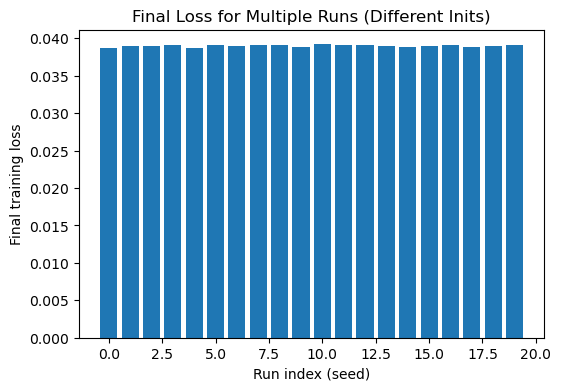

In [4]:
final_losses, final_params = run_multiple_inits_plot(
    X, Y,
    hidden_dims=[64, 32],
    learning_rate=0.01,
    num_runs=20,
    num_iterations=500
)